Autor: Karol Szwed\
Data: 17.02.2023 r.\
Przedmiot: Kurs programowania w Python\
Projekt: Końcowe zadanie zaliczeniowe - analiza danych z użyciem API dla ZTM w Warszawie

# Cel projektu

Korzystając z danych dostępnych na stronie https://api.um.warszawa.pl/ zbierane są informacje o pozycjach autobusów w zadanym przedziale czasu. Do analizy wzięte zostały pod uwagę dwa okresy 1-godzinne, dokładnie od 13:30 do 14:30 w czwartek oraz od 16:30 do 17:30 w piątek.

Na podstawie zebranych danych została przeprowadzona analiza:
 - Średniej prędkości autobusów (np. ile autobusów przekroczyło prędkość 50 km/h?)
 - Punktualność autobusów w obserwowanym okresie (porównanie rzeczywistego czasu dojazdu na przystanki z rozkładem jazdy).
 
Następnie wyniki przeprowadzonej analizy zostały zwizualizowane oraz opisane.

# Analiza danych

W drugiej części projektu należało zebrane dane zanalizować oraz zwizualizować, co zostanie zaprezentowane.

In [50]:
# All libraries used across the whole project
import warsaw_data_api
import datetime
import time
import json
import pandas as pd
import csv
import pickle
from collections import defaultdict
import geopy.distance
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.colors import Normalize
import numpy as np
from scipy.stats import gaussian_kde

import avg_speed_analysis
import my_pickle_save

_MY_API_KEY = "2620c061-1099-44d9-baab-fdc3a772ab29"  # My api key
_ZTM = warsaw_data_api.ztm(apikey=_MY_API_KEY)  # Pass api key
_BUS_GPS_RUSH_FILENAME = "Buses_location_rush.csv"
_BUS_GPS_FILENAME = "Buses_location_afternoon.csv"

## Analiza średniej prędkości autobusów

In [53]:
# Return time difference between two times ("time_1" and "time_2") in seconds.
def calculate_time_diff(time_1, time_2):
    time_format = "%H:%M:%S"
    t1 = datetime.datetime.strptime(time_1, time_format)
    t2 = datetime.datetime.strptime(time_2, time_format)
    return (t2 - t1).seconds  # keep as seconds


# Calculate distance in meters between two points, given as pairs of coordinates.
def calculate_distance(coords_1, coords_2):
    return geopy.distance.geodesic(coords_1, coords_2).meters  # convert to meters

In [54]:
# Returns all rows from a given CSV file that contain passed as parameter "vehicle_nr"
def get_vehicle_data(filename, vehicle_nr):
    with open(filename, 'r') as file:
        reader = csv.reader(file)
        rows = list(reader)
        bus_rows = [row for row in rows if row[-1] == vehicle_nr]
        vehicle_rows = defaultdict(list)
        for row in bus_rows:
            vehicle_rows[row[-1]].append(row)
        return vehicle_rows


# Returns a list of unique vehicle numbers present in the dataset
def get_vehicle_numbers(filename):
    with open(filename, 'r') as file:
        reader = csv.reader(file)
        rows = list(reader)
        vehicle_numbers = set(row[-1] for row in rows)
        return list(vehicle_numbers)

# Returns a list of vehicle numbers for a given bus line
def get_vehicle_numbers_for_line(filename, bus_line):
    with open(filename, 'r') as file:
        reader = csv.reader(file)
        rows = list(reader)
        bus_rows = [row for row in rows if row[0] == bus_line]
        vehicle_numbers = set(row[-1] for row in bus_rows)
        return list(vehicle_numbers)


# Returns a list of tuples with average speed information (across all consecutive GPS points)
def calculate_avg_speeds(filename, vehicle):
    vehicle_rows = get_vehicle_data(filename, vehicle)
    rows = vehicle_rows[vehicle]
    if len(rows) < 2:
        # Not enough GPS points to calculate average speed
        return None
    speeds = []
    for i in range(len(rows) - 1):
        coords_1 = (float(rows[i][1]), float(rows[i][2]))
        coords_2 = (float(rows[i + 1][1]), float(rows[i + 1][2]))
        distance = calculate_distance(coords_1, coords_2)
        time_diff = calculate_time_diff(rows[i][3], rows[i + 1][3])
        avg_speed = distance / time_diff  # m/s
        speeds.append((avg_speed, rows[i][3], rows[i + 1][3]))
    return speeds


# Applies function calculate_avg_speeds to all vehicles and returns a dictionary that aggregates this.
def get_avg_speeds_for_all_vehicles(filename, bus_line):
    vehicle_numbers = get_list_of_vehicle_numbers(filename, bus_line)
    avg_speeds = {}
    for vehicle in vehicle_numbers:
        avg_speeds[vehicle] = calculate_avg_speeds(filename, vehicle)
    return avg_speeds


# Example of usage:
# _BUS_GPS_FILENAME = "Buses_location_afternoon.csv"
# avg_speed_line = get_avg_speeds_for_all_vehicles(_BUS_GPS_FILENAME, '504')
# print(avg_speed_line)

# print(get_list_of_vehicle_numbers(_BUS_GPS_FILENAME, '504'))
# print(get_vehicle_data(_BUS_GPS_FILENAME, '8307'))

# print(calculate_avg_speeds(_BUS_GPS_FILENAME, '8818'))

{'8369': [(3.326181227031001, '13:31:05', '13:32:08'), (6.8764620530142775, '13:32:08', '13:33:20'), (7.378831705765759, '13:33:20', '13:34:11'), (0.8378385306792699, '13:34:11', '13:35:10'), (0.0, '13:35:10', '13:36:13'), (3.524511361610872, '13:36:13', '13:37:31'), (4.480870703191513, '13:37:31', '13:38:20'), (6.805857390233011, '13:38:20', '13:39:25'), (4.849956604302141, '13:39:25', '13:40:32'), (4.777990399342174, '13:40:32', '13:41:12'), (1.9546482403224938, '13:41:12', '13:42:20'), (6.221918050536933, '13:42:20', '13:43:24'), (3.3479787854153167, '13:43:24', '13:44:28'), (7.2638544750905005, '13:44:28', '13:45:33'), (4.136515764081299, '13:45:33', '13:46:51'), (5.042917111936268, '13:46:51', '13:48:13'), (4.310316216509724, '13:48:13', '13:49:00'), (2.470124320560013, '13:49:00', '13:50:21'), (1.4171649733550686, '13:50:21', '13:51:08'), (0.32196385550199386, '13:51:08', '13:52:12'), (0.031030376962087186, '13:52:12', '13:52:59'), (0.0, '13:52:59', '13:54:18'), (0.0, '13:54:18',

In [8]:
"""
 * INPUT:
    - "filename" - a string representing the name of the CSV file containing bus GPS data.
 * FUNCTION: Reads the bus GPS data from the CSV file, calculates the total distance traveled and total time spent by
    each vehicle, and calculates the average speed of each vehicle.
 * OUTPUT: Returns a pandas DataFrame with the vehicle number as the index and columns for the bus line, total distance
    (in meters), and total time (in minutes). The DataFrame is sorted by the total distance in descending order.
"""
def calculate_avg_speeds_for_all_vehicles(filename):
    with open(filename, 'r') as file:
        reader = csv.reader(file)
        next(reader)  # Skip the header
        rows = list(reader)
        vehicle_data = {}
        for row in rows:
            bus_line = row[0]
            vehicle_nr = row[-1]
            coords = (float(row[1]), float(row[2]))

            if vehicle_nr not in vehicle_data:
                vehicle_data[vehicle_nr] = [bus_line, 0, 0, (coords, row[3])]  # total_distance, total_time, last_row
            else:
                last_coords, last_time = vehicle_data[vehicle_nr][3]
                distance = calculate_distance(last_coords, coords)
                time_diff = calculate_time_diff(last_time, row[3])
                vehicle_data[vehicle_nr][1] += distance
                vehicle_data[vehicle_nr][2] += time_diff
                vehicle_data[vehicle_nr][3] = (coords, row[3])

        # Convert the vehicle_data dictionary to a list of dictionaries
        vehicle_data_list = [
            {'vehicle_nr': vehicle_nr, 'bus_line': data[0], 'total_distance_meters': round(data[1]),
             'total_time_mins': round(data[2] / 60, 1)}
            for vehicle_nr, data in vehicle_data.items()]

        # Create a DataFrame from the list of dictionaries
        vehicle_data_df = pd.DataFrame(vehicle_data_list)
        vehicle_data_df = vehicle_data_df.set_index('vehicle_nr')

        return vehicle_data_df

In [55]:
_BUS_GPS_FILENAME = "Buses_location_afternoon.csv"
avg_speeds = calculate_avg_speeds_for_all_vehicles(_BUS_GPS_FILENAME)
avg_speeds = avg_speeds.sort_values(by='total_distance_meters', ascending=False)

print(avg_speeds)

_BUS_GPS_RUSH_FILENAME = "Buses_location_rush.csv"
avg_speeds_rush = calculate_avg_speeds_for_all_vehicles(_BUS_GPS_RUSH_FILENAME)
avg_speeds_rush = avg_speeds_rush.sort_values(by='total_distance_meters', ascending=False)

print(avg_speeds_rush)

           bus_line  total_distance_meters  total_time_mins
vehicle_nr                                                 
4217            207                 980558             59.4
6208            733                  33176             59.5
4339            729                  28260             59.5
8338            727                  27971             59.5
70033           L14                  27875             59.5
...             ...                    ...              ...
2204            717                      0              0.0
5890            N31                      0              0.0
1011            213                      0              0.0
60054           L18                      0              0.0
8509            522                      0              0.0

[1523 rows x 3 columns]
           bus_line  total_distance_meters  total_time_mins
vehicle_nr                                                 
5405            705                  35679             48.4
9930           

In [61]:
# Save for later
avg_speeds = my_pickle_save.load_obj_from_pickle_file("avg_speeds.pkl")
avg_speeds_rush = my_pickle_save.load_obj_from_pickle_file("avg_speeds_rush.pkl")

Widzimy, że jeden z autobusów (linia nr 207) osiągnął zawrotną prędkość 980 km/h (średnia z całej godziny jazdy), tym samym usuwamy ten wpis z tabeli (jest to jedyna tak nieprawdopodobna prędkość, gdyż tabelę powyżej są posortowane).

In [56]:
# Remove first record in avg_speeds, as it contains improbable record
avg_speeds = avg_speeds.iloc[1:]

In [57]:
print(avg_speeds.head())
print(avg_speeds_rush.head())

           bus_line  total_distance_meters  total_time_mins
vehicle_nr                                                 
6208            733                  33176             59.5
4339            729                  28260             59.5
8338            727                  27971             59.5
70033           L14                  27875             59.5
35136           L25                  27277             60.0
           bus_line  total_distance_meters  total_time_mins
vehicle_nr                                                 
5405            705                  35679             48.4
9930            719                  31130             59.6
7727            733                  30942             59.5
7216            733                  30426             59.5
5249            719                  28561             59.5


Całkowity przejechany dystans przez autobusy:

In [58]:
# Calculate total distance traveled for all buses:
number_of_buses = len(get_vehicle_numbers(_BUS_GPS_FILENAME))
number_of_buses_rush = len(get_vehicle_numbers(_BUS_GPS_RUSH_FILENAME))

# In early afternoon
total_distance = avg_speeds['total_distance_meters'].sum()
print("Early afternoon:", round(total_distance / 1000), "km, by:", number_of_buses, "buses")

# In rush hour
total_distance_rush = avg_speeds_rush['total_distance_meters'].sum()
print("Rush hour: ", round(total_distance_rush / 1000), "km, by:", number_of_buses_rush, "buses")

Early afternoon: 17975 km, by: 1524 buses
Rush hour:  21566 km, by: 1567 buses


Wykresy średniej prędkości pogrupowane ze względu na linię autobusową:

In [59]:
"""
 * INPUT:
    - "avg_speeds_per_vehicle" - a DataFrame containing the total distance traveled and total time spent by each vehicle.
 * FUNCTION: Groups the DataFrame by the 'bus_line' column, calculates the total distance and total time for each
    bus line, and then calculates the average speed for each bus line.
 * OUTPUT: Returns a DataFrame with the bus line as the index and columns for the total distance (in meters),
    total time (in minutes), and average speed (in km/h).
"""
def calculate_avg_speeds_per_line(avg_speeds_per_vehicle):
    # Group by 'bus_line' and calculate the total distance and total time for each bus line
    line_data = avg_speeds_per_vehicle.groupby('bus_line').agg({'total_distance_meters': 'sum',
                                                                'total_time_mins': 'sum'})

    # Calculate the average speed for each bus line in kilometers per hour (km/h)
    line_data['avg_speed_kph'] = (line_data['total_distance_meters'] / 1000) / (line_data['total_time_mins'] / 60)

    return line_data


"""
 * INPUT:
    - "speeds_per_line" - a DataFrame with the bus line as the index and a column for the average speed (in km/h).
 * FUNCTION: Plots the average speed for each bus line.
 * OUTPUT: None. It creates a line plot of the average speed for each bus line, sorted in descending order by the
    average speed. The y-axis label is set to 'Average Speed (in km/h)', and the x-axis labels are hidden.
"""
def plot_avg_speed_per_line(speeds_per_line):
    speeds_per_line = speeds_per_line.sort_values(by='avg_speed_kph', ascending=False)
    plt.figure(figsize=(10, 6))
    plt.plot(speeds_per_line.index.tolist(), speeds_per_line['avg_speed_kph'].values.tolist())
    plt.ylabel('Average Speed (in km/h)')
    plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)  # hide x-axis labels

    # Add horizontal lines
    for y in range(0, int(speeds_per_line['avg_speed_kph'].max()) + 1, 1):  # change the step size to your preference
        plt.axhline(y, color='gray', linewidth=0.5)

    plt.show()

Early afternoon


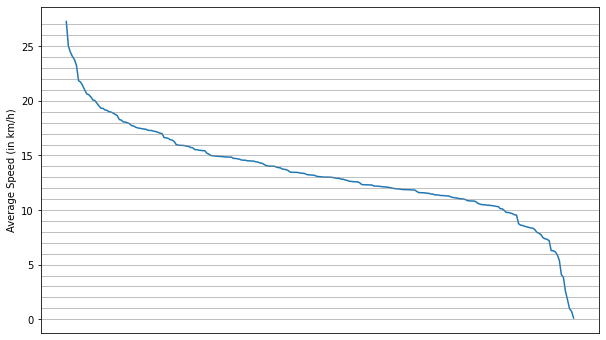

Rush hour


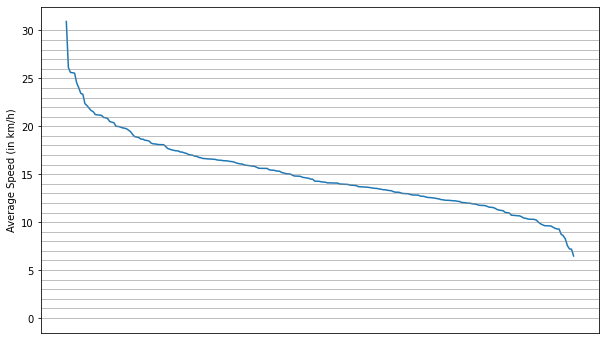

In [60]:
avg_speeds_per_line = calculate_avg_speeds_per_line(avg_speeds)
print("Early afternoon")
plot_avg_speed_per_line(avg_speeds_per_line)

avg_speeds_per_line = calculate_avg_speeds_per_line(avg_speeds_rush)
print("Rush hour")
plot_avg_speed_per_line(avg_speeds_per_line)

## Analiza punktualności

Aby zmierzyć punktualność autobusów, wykorzystałem dane GPS, wcześniej utworzony słownik z trasami dla każdej linii oraz rozkład jazdy danej linii, mianowicie:
1. Sprawdzamy, czy autobus jest blisko jednego ze swoich przystanków (tu: w promieniu 60 m od przystanku).
2. Jeśli tak, to sprawdzamy rozkład jazdy dla danego przystanku.
3. Jeśli jest w rozkładzie jazdy zaplanowany autobus o pasującym numerze linii oraz numerze brygady, to zaliczamy dany rekord jako autobus znajdujący się na przystanku i obliczamy jest opóźnienie

In [15]:
# Calculate distance between two points given as coordinates.
def calculate_distance(lat1, lon1, lat2, lon2):
    coords_1 = (lat1, lon1)  # point A
    coords_2 = (lat2, lon2)  # point B
    return geopy.distance.geodesic(coords_1, coords_2).meters  # convert to meters


# Read GPS and bus stops data from their respective files.
def read_data(gps_file, stops_file):
    bus_gps_data = pd.read_csv(gps_file)
    bus_stops_data = my_pickle_save.load_obj_from_pickle_file(stops_file)
    return bus_gps_data, bus_stops_data


# Check if a bus is within "distance_threshold" from any of its bus stops.
def is_bus_near_stop(bus, bus_stops_data, distance_threshold=60):
    bus_line = bus['lines']
    if bus_line in bus_stops_data:
        for stop in bus_stops_data[bus_line]:
            # Pass the bus and stop coordinates to the function;
            # stop[4] and stop[5] are latitude and longitude of the stop.
            distance = calculate_distance(bus['latitude'], bus['longitude'],
                                          stop[4], stop[5])
            if distance <= distance_threshold:
                return True, stop
    return False, None


# Return a schedule for a given bus stop id, stop pole number, and a bus line.
def get_schedule(stop_id, stop_pole, line):
    return _ZTM.get_bus_stop_schedule_by_id(stop_id, stop_pole, line)


# Change hour value in time stamp so that it is in format 'HH:MM:SS'
def check_if_ride_time_is_valid(ride_time):
    # Check if ride.time hour is bigger than 23 and if so, change it to 00
    # (we collected data outside the night anyway)
    hour = int(ride_time.split(':')[0])
    if hour > 23:
        ride_time = '00' + ride_time[2:]
    return ride_time


"""
 * INPUT:
    - "schedule" - a Schedule object containing the bus schedule for a specific stop.
    - "brigade" - a string representing the brigade number of the bus.
    - "bus_time" - a string representing the time the bus was at the stop in the format 'HH:MM:SS'.
    - "time_threshold" - a tuple specifying the minimum and maximum time difference (in minutes) between the actual and
        scheduled arrival times for a match to be considered valid. Default is (-3, 20).
 * FUNCTION: Iterates over each ride in the schedule, checks if the brigade number matches, and if so,
    calculates the delay between the actual and scheduled arrival times. If the time difference is within the specified
    threshold, it considers it a match.
 * OUTPUT: Returns a tuple of three elements. The first element is a boolean indicating whether a match was found.
    The second element is the scheduled time of the matching ride (or None if no match was found).
    The third element is the delay between the actual and scheduled arrival times (or None if no match was found).
"""
def is_matching_entry_in_schedule(schedule, brigade, bus_time, time_threshold=(-3, 20)):
    bus_time = datetime.datetime.strptime(bus_time, '%H:%M:%S')
    for ride in schedule.rides:
        ride.time = check_if_ride_time_is_valid(ride.time)
        scheduled_time = datetime.datetime.strptime(ride.time, '%H:%M:%S')
        time_difference = (bus_time - scheduled_time).total_seconds() / 60  # in minutes

        if time_threshold[0] <= time_difference <= time_threshold[1] and ride.brigade == brigade:
            return True, scheduled_time, time_difference
    return False, None, None

In [14]:
"""
 * INPUT:
    - "results_filename" - a string representing the name of the CSV file where the results will be written.
 * FUNCTION: Reads bus GPS data and bus stops data, iterates over each bus in the GPS data, checks if the
    bus is near a stop, and if so, checks if there is a matching entry in the schedule for the bus. If there is a match,
    it calculates the time difference between the actual and scheduled arrival times, adds this information to the
    bus data, and writes the updated bus data to the results file. Thus bus arrival data is created.
 * OUTPUT: Returns a pandas DataFrame containing the updated bus data with additional columns for the scheduled time,
    time difference, and stop information. Also, as a side effect, it writes the updated bus data to a CSV file.
    This way updates are online and in case of a crash, the data is saved.
"""
def calculate_time_difference(results_filename):
    bus_gps_data, bus_stops_data = read_data(_BUS_GPS_FILENAME, _BUS_STOPS_FILENAME)
    result = pd.DataFrame(columns=bus_gps_data.columns.tolist() + ['scheduled_time', 'time_difference',
                                                                   'stop_id', 'stop_pole', 'stop_name'])

    file = open(results_filename, 'w', newline='')
    writer = csv.writer(file)
    writer.writerow(result.columns.tolist())  # write header
    for index, bus in bus_gps_data.iterrows():
        is_near, stop = is_bus_near_stop(bus, bus_stops_data)
        if is_near:
            # If bus stop ID is not in base 10, continue to the next iteration
            if not stop[0].isdigit():
                continue

            # Pass the stop_id, stop_pole and bus line number to the function
            schedule = get_schedule(stop[0], stop[1], bus['lines'])

            is_match, scheduled_time, time_difference = (
                is_matching_entry_in_schedule(schedule, bus['brigade'], bus['time'])
            )

            if is_match:
                bus['scheduled_time'] = scheduled_time.time().strftime('%H:%M:%S')
                bus['time_difference'] = time_difference
                bus['stop_id'] = stop[0]  # stop['stop_id']
                bus['stop_pole'] = stop[1]  # stop['stop_pole']
                bus['stop_name'] = stop[2]  # stop['stop_name']

                result.loc[len(result)] = bus
                writer.writerow(bus.tolist())  # Write results row to CSV file
    file.close()
    return result

In [ ]:
# Example of usage:
# _BUS_GPS_FILENAME = "Buses_location_rush.csv"
# _BUS_STOPS_FILENAME = "bus_line_stops.pkl"
# _BUS_PUNCTUALITY_RESULTS_FILENAME = "bus_punctuality_rush_results.csv"
# bus_punctuality_df = calculate_time_difference(_BUS_PUNCTUALITY_RESULTS_FILENAME)
# my_pickle_save.save_obj_as_pickle_file(bus_punctuality_df, "bus_punctuality_rush_df.pkl")

Niestety każde żądanie wysłane do API zajmuje 0.3s oraz co pewien czas API przestawało odpowiadać na żądania, tym samym z uwagi na ograniczenia czasowe przeprowadzania eksperymentu zebrane zostało ok. 6500 rekordów autobusów w pobliżu przystanków dla danych wczesnopopołudniowych oraz ok. 2500 rekordów dla danych w godzinie szczytu.

In [18]:
_BUS_PUNCTUALITY_RUSH_RESULTS_FILENAME = "bus_punctuality_rush_results.csv"
_BUS_PUNCTUALITY_RESULTS_FILENAME = "bus_punctuality_results.csv"

pd.set_option('display.max_columns', None)  # Display all columns

In [23]:
bus_punctuality_df = pd.read_csv(_BUS_PUNCTUALITY_RESULTS_FILENAME)
print(bus_punctuality_df.head())

bus_punctuality_rush_df = pd.read_csv(_BUS_PUNCTUALITY_RUSH_RESULTS_FILENAME)
print(bus_punctuality_rush_df.head())

# Calculate the average time difference for all buses
avg_time_difference = bus_punctuality_df['time_difference'].mean()
print("Average time difference in early afternoon:", round(avg_time_difference, 1))

# Second dataset
avg_time_difference_rush = bus_punctuality_rush_df['time_difference'].mean()
print("Average time difference in rush hour:", round(avg_time_difference_rush, 1))

  lines   latitude  longitude      time  brigade  vehicle_number  \
0   213  52.160051  21.223366  13:31:12        1            1003   
1   225  52.222961  21.101779  13:31:12      501            1009   
2   213  52.214196  21.142529  13:31:11        5            1012   
3   213  52.222792  21.102464  13:30:53        4            1014   
4   108  52.182369  21.056813  13:31:14        2            1034   

  scheduled_time  time_difference  stop_id  stop_pole      stop_name  
0       13:33:00        -1.800000     2162          2    Wasilkowska  
1       13:30:00         1.200000     2148          4         Gocław  
2       13:28:00         3.183333     2264          1   Pielęgniarek  
3       13:11:00        19.883333     2148          5         Gocław  
4       13:29:00         2.233333     3033         55  św.Bonifacego  
  lines   latitude  longitude      time  brigade  vehicle_number  \
0   219  52.190505  21.149064  16:32:46        1            1001   
1   213  52.212408  21.108400

Jak widać, autobusy w godzinach szczytu mają średnio o 3 min większe opóźnienie. Różnica nie jest duża, gdyż drugi zbiór danych GPS był zbierany od 16:30 (więc z czasem natężenie ruchu by rosło). Gdyby wybrać inne przedziały, np. godzina wczesnoporanna (np. od 6:00) oraz jako godzinę szczytu uznać przedział od 17:30 do 18:30, to możemy podejrzewać, że różnica w średnim czasie spóźnienia by się zwiększyła.

Teraz uwzględnijmy podział na poszczególnie linie autobusowe:

In [24]:
# Calculate the average time difference for each bus line
avg_time_difference_per_line = bus_punctuality_df.groupby('lines')['time_difference'].mean()
print("Average time difference for each bus line:")
print(avg_time_difference_per_line.sort_values(ascending=False))

# Second dataset
avg_time_difference_per_line_rush = bus_punctuality_rush_df.groupby('lines')['time_difference'].mean()
print("Average time difference for each bus line during rush hours:")
print(avg_time_difference_per_line_rush.sort_values(ascending=False))

Average time difference for each bus line:
lines
314    15.812500
196    13.671429
181    13.480741
217    12.192735
125    11.804212
         ...    
L12    -1.008333
L-8    -1.050000
712    -1.116667
356    -1.395833
319    -1.966667
Name: time_difference, Length: 222, dtype: float64
Average time difference for each bus line during rush hours:
lines
707    16.516667
L49    16.475000
736    15.016667
210    14.566667
129    14.431944
         ...    
218     1.619792
131     1.383333
L-3     0.520833
705     0.405556
135    -0.066667
Name: time_difference, Length: 141, dtype: float64


In [33]:
"""
 * INPUT:
    - "time_diff_per_line" - a pandas Series where the index is the bus line and the value is the average delay for
        that line.
 * FUNCTION: Sorts the input Series in descending order, creates a new figure, and plots the average delay
    for each bus line.
 * OUTPUT: None. As a side effect, it displays a line plot of the average delay for each bus line.
"""
def plot_avg_time_difference_per_line(time_diff_per_line):
    time_diff_per_line = time_diff_per_line.sort_values(ascending=False)
    plt.figure(figsize=(10, 6))
    plt.plot(time_diff_per_line.index.tolist(), time_diff_per_line.values.tolist())
    plt.ylabel('Time difference (in minutes)')
    plt.title('Avg. time difference')
    plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)  # Hide x-axis labels
    
    # Add horizontal lines
    for y in range(0, int(time_diff_per_line.max()) + 1, 1):  # change the step size to your preference
        plt.axhline(y, color='gray', linewidth=0.5)
    
    plt.show()

In early afternoon


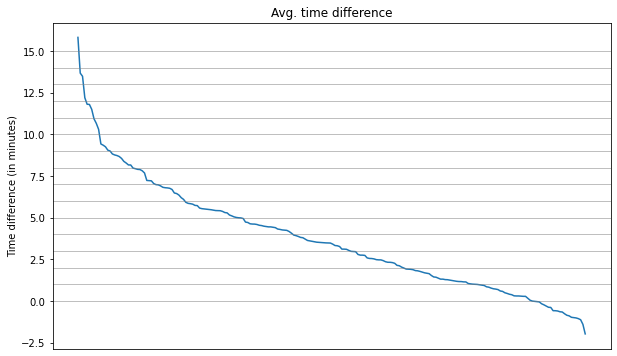

In rush hour


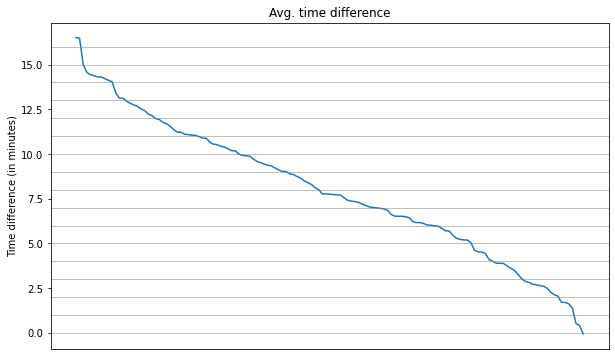

In [34]:
# Plot the average time difference for each bus line
print("In early afternoon")
plot_avg_time_difference_per_line(avg_time_difference_per_line)
print("In rush hour")
plot_avg_time_difference_per_line(avg_time_difference_per_line_rush)

### Heatmapa

Teraz nałożymy opóźnienia autobusów na konkretne przystanki jako heatmapę nałożoną na mapę Warszawy.

In [37]:
"""
 * INPUT:
    - "bus_arrival" - a pandas DataFrame containing bus arrival data.
    - "map_image_path" - a string representing the path to the map image file.
    - "lat_bounds" - a tuple specifying the minimum and maximum latitude values of the map image.
    - "lon_bounds" - a tuple specifying the minimum and maximum longitude values of the map image.
 * FUNCTION: Filters out points that do not fit on the map, normalizes the time difference values to a
    range suitable for color mapping, estimates the density of points, creates a grid of points covering the map, and
    plots the density as a heatmap. It also plots the points on the map with their color representing the delay.
 * OUTPUT: None. As a side effect displays a heatmap of bus arrival times on a map image. The color on the map
    represents the time difference of the bus arrival, with 'hot' areas indicating longer delays.
 """
def plot_heatmap_on_map(bus_arrival, map_image_path, lat_bounds, lon_bounds):
    # Load the map image
    map_img = mpimg.imread(map_image_path)

    # Filter out points that do not fit on the map
    bus_arrival = bus_arrival[(bus_arrival['latitude'] >= lat_bounds[0]) & (bus_arrival['latitude'] <= lat_bounds[1]) &
                              (bus_arrival['longitude'] >= lon_bounds[0]) & (bus_arrival['longitude'] <= lon_bounds[1])]

    # Normalize the time difference values to a range suitable for color mapping
    norm = Normalize(vmin=bus_arrival['time_difference'].min(), vmax=bus_arrival['time_difference'].max())

    # Estimate the density of points
    xy = np.vstack([bus_arrival['longitude'], bus_arrival['latitude']])
    z = gaussian_kde(xy)(xy)

    # Create a grid of points covering the map
    xi, yi = np.mgrid[lon_bounds[0]:lon_bounds[1]:100j, lat_bounds[0]:lat_bounds[1]:100j]
    zi = gaussian_kde(xy)(np.vstack([xi.flatten(), yi.flatten()]))

    # Create a new figure
    plt.figure(figsize=(15, 10))

    # Display the map image
    plt.imshow(map_img, extent=[lon_bounds[0], lon_bounds[1], lat_bounds[0], lat_bounds[1]])

    # Plot the density as a heatmap
    plt.imshow(zi.reshape(xi.shape), origin='lower', aspect='auto',
               extent=[lon_bounds[0], lon_bounds[1], lat_bounds[0], lat_bounds[1]],
               cmap='hot', alpha=0.5)

    # Plot the points
    plt.scatter(bus_arrival['longitude'], bus_arrival['latitude'], c=z, cmap='hot', norm=norm, alpha=0.5, s=2)

    # Add a color bar
    plt.colorbar(label='time_difference (in mins)')

    # Show the plot
    plt.show()

Early afternoon


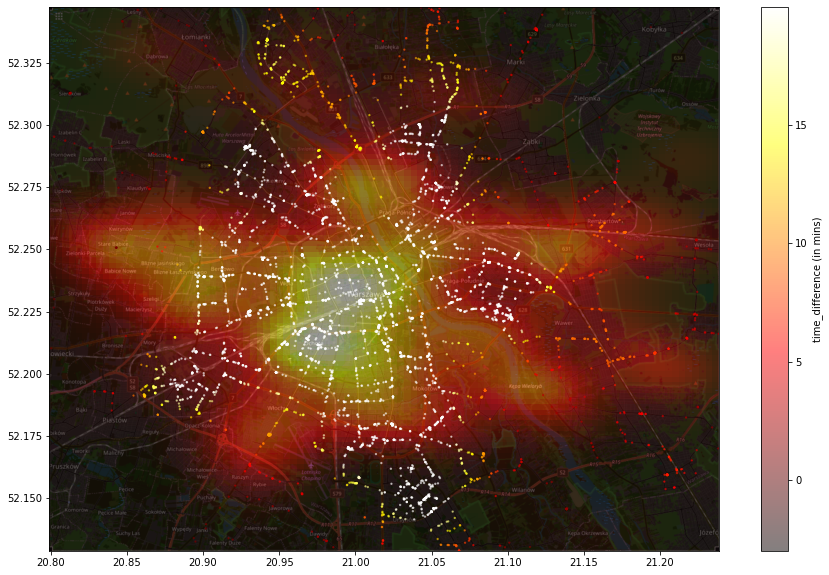

Rush hour


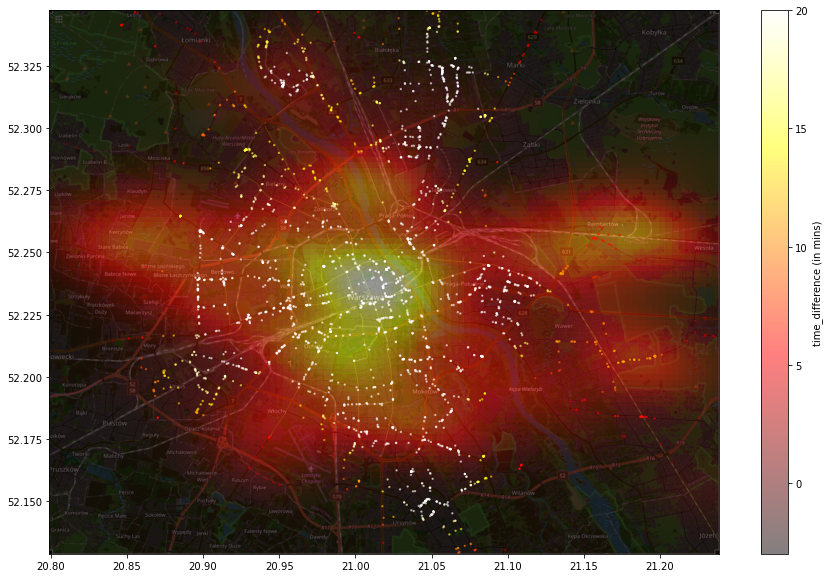

In [39]:
warsaw_map_img = "WAW_MAP.png"
latitude_span = (52.1289, 52.3473)
longitude_span = (20.7992, 21.2386)

# Plot as heat map the delay for each record in the dataset on real world map - early afternoon
print("Early afternoon")
plot_heatmap_on_map(bus_punctuality_df, warsaw_map_img, latitude_span, longitude_span)

# Plot as heat map the delay for each record in the dataset on real world map - rush hour
print("Rush hour")
plot_heatmap_on_map(bus_punctuality_rush_df, warsaw_map_img, latitude_span, longitude_span)

Obszary bardziej "ciepłe" (bielsze) reprezentują obszary gdzie opóźnienia były największe.